To convert this `md` notebook into a standard Jupyter notebook (`ipynb`), use the following command in the command line (in the folder of this notebook):

`jupytext --to ipynb guide-building-blocks.md`

# Recording Experiment Workflow Results

While running an experiment workflow one would like to keep a record of what took place -- a kind of digital lab book. The LabOne Q Applications Library provides logbooks for just this task.

Each workflow being run has its own logbook. The logbook record the tasks being run and may also be used to store additional data such as device settings, LabOne Q experiments, qubits, and the results of experiments and analyses.

Logbooks need to be stored somewhere and within the application library this place is called a logbook store.

Currently the applications library supports two kinds of stores:

* `FolderStore`
* `LoggingStore`

The `FolderStore` writes logbooks to a folder on disk. It is used to keep a permanent record of the experiment workflow.

The `LoggingStore` just logs what is happening using Python's logging. It provides a quick overview of the steps performed by a workflow.

We'll look at each of these in more detail shortly, but first let us set up a quantum platform to run some experiments on so we have something to record.

## Setting up a quantum platform

Build your LabOne Q `DeviceSetup`, qubits and `Session` as normal. Here we import a demonstration tunable transmon quantum platform from the library and the amplitude Rabi experiment:

In [1]:
import numpy as np
from laboneq.simple import *
from laboneq_applications.experiments import amplitude_rabi
from laboneq_applications.qpu_types.tunable_transmon import demo_platform

In [2]:
# Create a demonstration QuantumPlatform for a tunable-transmon QPU:
qt_platform = demo_platform(n_qubits=6)

# The platofrm contains a setup, which is an ordinary LabOne Q DeviceSetup:
setup = qt_platform.setup

# And a tunable-transmon QPU:
qpu = qt_platform.qpu

# Inside the QPU, we have qubits, which is a list of six LabOne Q Application Library TunableTransmonQubit qubits:
qubits = qpu.qubits

In [3]:
session = Session(setup)
session.connect(do_emulation=True)

[2024.08.14 13:16:54.597] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is C:\working_folder\laboneq-applications\examples\laboneq_output\log
[2024.08.14 13:16:54.613] INFO    VERSION: laboneq 1.0+local
[2024.08.14 13:16:54.624] INFO    Connecting to data server at localhost:8004
[2024.08.14 13:16:54.647] INFO    Connected to Zurich Instruments LabOne Data Server version 24.04 at localhost:8004
[2024.08.14 13:16:54.663] INFO    Configuring the device setup
[2024.08.14 13:16:54.717] INFO    The device setup is configured


## The LoggingStore

When you import the `laboneq_applications` library it automatically creates a default `LoggingStore` for you. This logging store is used whenever a workflow is executed and logs information about:

* the start and end of workflows
* the start and end of tasks
* any errors that occur
* comments (adhoc messages from tasks, more on these later)
* any data files that would be saved if a folder store was in use (more on these later too) 

These logs don't save anything obviously, but they will allow us to see what events are recorded and what would be saved if we did a have a folder store active.

### An example of logging

Let's run the amplitude Rabi experiment and take a look:

In [4]:
amplitudes = np.linspace(0.0, 0.9, 10)
options = amplitude_rabi.options()
options.create_experiment.count = 10
options.create_experiment.averaging_mode = "cyclic"
rabi_tb = amplitude_rabi.experiment_workflow(
    session,
    qpu,
    qubits[0],
    amplitudes,
    options=options,
)

The workflow has not yet been executed, but when you run the next cell, you should see messages like:

```
──────────────────────────────────────────────────────────────────────────────
 Workflow 'experiment_workflow': execution started
────────────────────────────────────────────────────────────────────────────── 
```

appear in the logs beneath the cell.

In [5]:
result = rabi_tb.run()

[2024.08.14 13:18:35.459] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.14 13:18:35.461] INFO      Workflow 'experiment_workflow': execution started                             
[2024.08.14 13:18:35.462] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.14 13:18:35.471] INFO    Task 'create_experiment': started
[2024.08.14 13:18:35.477] INFO    Task 'create_experiment': ended
[2024.08.14 13:18:35.478] INFO    Task 'compile_experiment': started
[2024.08.14 13:18:35.494] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal '/logical_signal_groups/q0/acquire' to SOFTWARE
[2024.08.14 13:18:35.500] INFO    Resolved modulation type of oscillator 'q0_drive_ge_osc' on signal '/logical_signal_groups/q0/drive' to HARDWARE
[2024.08.14 13:18:35.505] INFO    Resolved modulation type of oscillator 'q0_drive_ef_osc' on signal '/logical_signal_groups/q0/drive_ef' to HARDWARE

And that's all there is to the basic logging functionality.

### Advanced logging uses

If for some reason you need to create a logging store of your own you can do so as follows:

In [6]:
from laboneq_applications.logbook import LoggingStore

logging_store = LoggingStore()

The logging store created above won't be active unless you run:

In [7]:
logging_store.activate()

And you deactivate it with:

In [8]:
logging_store.deactivate()

And you can access the default logging store by importing it from `laboneq_applications.logbook` if you really need to:

In [9]:
from laboneq_applications.logbook import DEFAULT_LOGGING_STORE
DEFAULT_LOGGING_STORE

## The FolderStore

### Using the folder store

The folder stores workflow results on disk and is likely the most important logbook store you'll use.

You can import it as follows:

In [10]:
from laboneq_applications.logbook import FolderStore

To create a folder store you'll need to pick a folder on disk to store logbooks in. Here we select `./experiment_store` as the folder name but you should pick your own.

Each logbook created by a workflow will have its own sub-folder. The sub-folder name will start with a timestamp, followed by the name of the workflow, for example `20240728T175500-amplitude-rabi/`. If necessary, a unique count will be added at the end to make the sub-folder name unique.

The folder store will need to be activated before workflows will use it automatically.

In [11]:
folder_store = FolderStore("./experiment_store")
folder_store.activate()

Now let's run the amplitude Rabi workflow. As before we'll see the task events being logged. Afterwards we'll explore the folder to see what has been written to disk.

In [12]:
result = rabi_tb.run()

[2024.08.14 13:21:30.872] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.14 13:21:30.872] INFO      Workflow 'experiment_workflow': execution started                             
[2024.08.14 13:21:30.879] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.14 13:21:30.886] INFO    Task 'create_experiment': started
[2024.08.14 13:21:30.896] INFO    Task 'create_experiment': ended
[2024.08.14 13:21:30.902] INFO    Task 'compile_experiment': started
[2024.08.14 13:21:30.921] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal '/logical_signal_groups/q0/acquire' to SOFTWARE
[2024.08.14 13:21:30.928] INFO    Resolved modulation type of oscillator 'q0_drive_ge_osc' on signal '/logical_signal_groups/q0/drive' to HARDWARE
[2024.08.14 13:21:30.929] INFO    Resolved modulation type of oscillator 'q0_drive_ef_osc' on signal '/logical_signal_groups/q0/drive_ef' to HARDWARE

If you no longer wish to automatically store workflow results in the folder store, you can deactivate it with:

In [13]:
folder_store.deactivate()

### Exploring what was written to disk

Here we will use Python's `pathlib` functionality to explore what has been written to disk, but you can also use whatever ordinary tools you prefer (terminal, file navigator).

In [14]:
import json
from pathlib import Path

Remember that above we requested that the folder store use a folder named `experiment_store`. Let's list the logbooks that were created in that folder:

In [15]:
store_folder = Path("experiment_store")

amplitude_rabi_folders = sorted(store_folder.glob("*-experiment-workflow"))
amplitude_rabi_folders

[WindowsPath('experiment_store/20240814T112130-experiment-workflow')]

Our amplitude Rabi experiment is the most recent one run, so let's look at the files within the most recent folder. Note that the logbook folder names start with a timestamp followed by the name of the workflow which allows us to easily order them by time and to find workflow we're looking for:

In [16]:
amplitude_rabi_folder = amplitude_rabi_folders[-1]

amplitude_rabi_files = sorted(amplitude_rabi_folder.iterdir())
amplitude_rabi_files

[WindowsPath('experiment_store/20240814T112130-experiment-workflow/log.jsonl')]

At the moment there is only a single file saved. This is the log of what took place. The log is stored in a format called "JSONL" which means each line of the log is a simple Python dictionary stored as JSON.

Let's open the file and list the logs:

In [17]:
experiment_log = amplitude_rabi_folder / "log.jsonl"
logs = [
    json.loads(line) for line in experiment_log.read_text().splitlines()
]
logs

[{'event': 'start'},
 {'event': 'task_start', 'task': 'create_experiment'},
 {'event': 'task_end', 'task': 'create_experiment'},
 {'event': 'task_start', 'task': 'compile_experiment'},
 {'event': 'task_end', 'task': 'compile_experiment'},
 {'event': 'task_start', 'task': 'run_experiment'},
 {'event': 'task_end', 'task': 'run_experiment'},
 {'event': 'end'}]

In the remaining sections we'll look at how to write adhoc comments into the logs and how to save data files to disk.

## Logging comments from within tasks

Logbooks allow tasks to add their own messages to the logbook as comments.

This is done by calling the `comment(...)` function within a task.

We'll work through an example below:

In [19]:
from laboneq_applications.workflow import task, workflow
from laboneq_applications.logbook import comment

Let's write a small workflow and a tiny task that just writes a comment to the logbook:

In [20]:
@task
def log_a_comment(msg):
    comment(msg)

@workflow
def demo_comments():
    log_a_comment("Activating multi-state discrimination! <sirens blare>")
    log_a_comment("Analysis successful! <cheers>")

Now when we run the workflow we'll see the comments appear in the logs:

In [21]:
wf = demo_comments()
result = wf.run()

[2024.08.14 13:24:22.564] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.14 13:24:22.565] INFO      Workflow 'demo_comments': execution started                                   
[2024.08.14 13:24:22.568] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.14 13:24:22.571] INFO    Task 'log_a_comment': started
[2024.08.14 13:24:22.573] INFO    Comment: Activating multi-state discrimination! <sirens blare>
[2024.08.14 13:24:22.580] INFO    Task 'log_a_comment': ended
[2024.08.14 13:24:22.585] INFO    Task 'log_a_comment': started
[2024.08.14 13:24:22.587] INFO    Comment: Analysis successful! <cheers>
[2024.08.14 13:24:22.592] INFO    Task 'log_a_comment': ended
[2024.08.14 13:24:22.594] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.14 13:24:22.596] INFO      Workflow 'demo_comments': execution ended                                     
[20

Above you should see the two comments. They look like this:
```
Comment: Activating multi-state discrimination! <sirens blare>
...
Comment: Analysis successful! <cheers>
```

## Store data from within tasks

Logbooks also allow files to be saved to disk using the function `save_artifact`.

Here we will create a figure with matplotlib and save it to disk. The folder store will automatically save it as a PNG.

The kinds of objects the folder store can currenly save are:

* Python strings (saved as a text file)
* Python bytes (saved as raw data)
* Pydantic models (saved as JSON)
* PIL images (saved as PNGs by default)
* Matplotlib figures (saved as PNGs by default)
* Numpy arrays (saved as Numpy data files)

Support for more kinds of objects coming soon (e.g. `DeviceSetup`, `Experiment`).

In [22]:
import PIL
from matplotlib import pyplot as plt

from laboneq_applications.logbook import save_artifact

Let's write a small workflow that plots the sine function and saves the plot using `save_artifact`:

In [23]:
@task
def sine_plot():
    fig = plt.figure()
    plt.title("A sine wave")
    x = np.linspace(0, 2 * np.pi, 100)
    y = np.sin(x)
    plt.plot(x, y)

    save_artifact("Sine Plot", fig)

@workflow
def demo_saving():
    sine_plot()

Since we deactivate the folder store, let's activate it again now:

In [24]:
folder_store.activate()

And run our workflow:

[2024.08.14 13:25:40.615] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.14 13:25:40.615] INFO      Workflow 'demo_saving': execution started                                     
[2024.08.14 13:25:40.615] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.14 13:25:40.630] INFO    Task 'sine_plot': started
[2024.08.14 13:25:40.712] INFO    Artifact: 'Sine Plot' of type 'Figure' logged
[2024.08.14 13:25:40.982] INFO    Task 'sine_plot': ended
[2024.08.14 13:25:40.991] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.14 13:25:40.991] INFO      Workflow 'demo_saving': execution ended                                       
[2024.08.14 13:25:40.995] INFO     ────────────────────────────────────────────────────────────────────────────── 


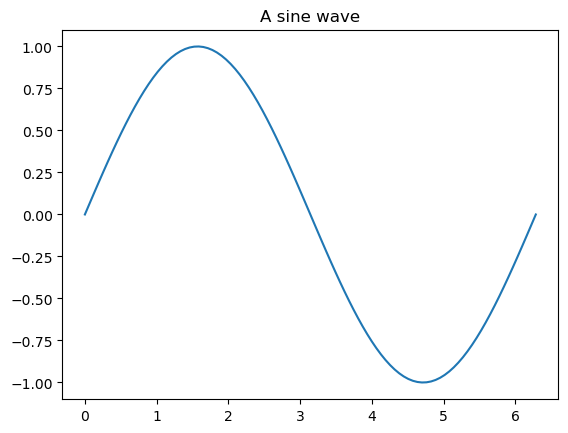

In [25]:
wf = demo_saving()
result = wf.run()

You can see in the logs that an artifact was created:
```
Artifact: 'Sine Plot' of type 'Figure' logged
```
Now let's load the image from disk.

First we need to find the logbook folder created for our workflow:

In [26]:
demo_saving_folders = sorted(store_folder.glob("*-demo-saving"))
demo_saving_folder = demo_saving_folders[-1]
demo_saving_folder

WindowsPath('experiment_store/20240814T112540-demo-saving')

And let's list its contents:

In [27]:
sorted(demo_saving_folder.iterdir())

[WindowsPath('experiment_store/20240814T112540-demo-saving/log.jsonl'),
 WindowsPath('experiment_store/20240814T112540-demo-saving/Sine Plot.png')]

And lastly let's load the saved image using PIL:

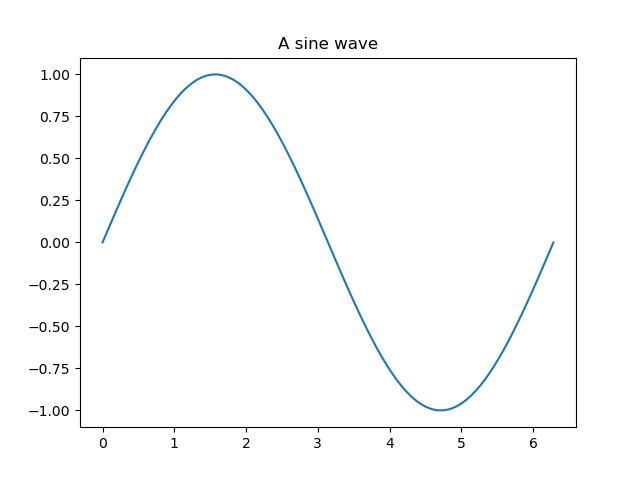

In [28]:
PIL.Image.open(demo_saving_folder / "Sine Plot.png")

And we're done!